# Quantitatively comparing ensembles in IDPET

In this Jupyter notebook, we are going use IDPET to quantitatively compare 3D structural ensembles.

We will compare three PED ensembles of the drkN SH3 domain ([PED00156](https://proteinensemble.org/entries/PED00156), [PED00157](https://proteinensemble.org/entries/PED00157) and [PED00158](https://proteinensemble.org/entries/PED00158)). Please refer to the `sh3_example.ipynb` notebook for more information about these three ensembles.

Here, the goal is to illustrate in more detail the methods for quantitatively comparing ensembles in IDPET.

## Part 1: setting up

### Load ensembles

We begin by loading the three ensembles as usual in IDPET. We will directly download them from PED.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dpet.ensemble_analysis import EnsembleAnalysis
from dpet.ensemble import Ensemble
from dpet.visualization import plot_comparison_matrix, Visualization


ensembles = [
    Ensemble(code='PED00156e001', database='ped'),
    Ensemble(code='PED00157e001', database='ped'),
    Ensemble(code='PED00158e001', database='ped')
]
data_dir = '/home/giacomo/projects/ensemble_analysis/out'

analysis = EnsembleAnalysis(ensembles, data_dir)
analysis.load_trajectories()

Download complete. Saved to: /home/giacomo/projects/ensemble_analysis/out/PED00156e001.tar.gz
Downloaded file PED00156e001.tar.gz from PED.
Extracted file PED00156e001.pdb.
Download complete. Saved to: /home/giacomo/projects/ensemble_analysis/out/PED00157e001.tar.gz
Downloaded file PED00157e001.tar.gz from PED.
Extracted file PED00157e001.pdb.
Download complete. Saved to: /home/giacomo/projects/ensemble_analysis/out/PED00158e001.tar.gz
Downloaded file PED00158e001.tar.gz from PED.
Extracted file PED00158e001.pdb.
PED00156e001 chain ids: ['A']
Generating trajectory for PED00156e001...
Generated trajectory saved to /home/giacomo/projects/ensemble_analysis/out.
PED00157e001 chain ids: ['A']
Generating trajectory for PED00157e001...
Generated trajectory saved to /home/giacomo/projects/ensemble_analysis/out.
PED00158e001 chain ids: ['A']
Generating trajectory for PED00158e001...
Generated trajectory saved to /home/giacomo/projects/ensemble_analysis/out.


{'PED00156e001': <mdtraj.Trajectory with 100 frames, 941 atoms, 59 residues, without unitcells at 0x7f21b418be50>,
 'PED00157e001': <mdtraj.Trajectory with 100 frames, 939 atoms, 59 residues, without unitcells at 0x7f21b458bdc0>,
 'PED00158e001': <mdtraj.Trajectory with 88 frames, 939 atoms, 59 residues, without unitcells at 0x7f21b59d3e50>}

### Summary table

Before starting the analysis, let's use the `get_features_summary_dataframe()` method to obtain a summary of information on the ensembles.

We can look at the number of residues and number of conformers, as well as some useful global descriptors (such as radius-of-gyration).

In [2]:
analysis.get_features_summary_dataframe(
    selected_features=["rg", "asphericity", "end_to_end"],
    show_variability=False
)

,ensemble_code,n_residues,n_conformers,rg_mean,asphericity_mean,end_to_end_mean
0,PED00156e001,59,100,1.793522,0.367338,4.334907
1,PED00157e001,59,100,1.908008,0.480395,4.339479
2,PED00158e001,59,88,1.867024,0.527425,4.378268


### Setting up a visualization object

There are several ways in which we can perform quantitative ensemble comparisons in IDPET.

The easiest way is to use comparison functions via the `visualization` module. We will begin by using this strategy.

Later, we will see how to use a lower-level API to have more control.

In [3]:
vis = Visualization(analysis)  # Initializes a Visualization object for the analysis.

## Part 2 (preliminary analysis): qualitive comparisons of molecular features

In this notebook, the quantitative methods for comparing ensembles work in a simple way. They look at two types of molecular features: $C\alpha$-$C\alpha$ distances and $\alpha$ torsion angles (that is, the torsions between four consecutive $C\alpha$ atoms in a protein).

When making a comparison, the methods attempt to score the divergence (or distance) between ensembles based on the distribution of these features.

Before performing the actual scoring, let’s first visualize the actual distributions of these features using histograms. 

This qualitative analysis will be useful to better makes sense of the numerical scores.

### $C\alpha$-$C\alpha$ distances

First, let’s plot histograms of $C\alpha$-$C\alpha$ distances between some random residues.

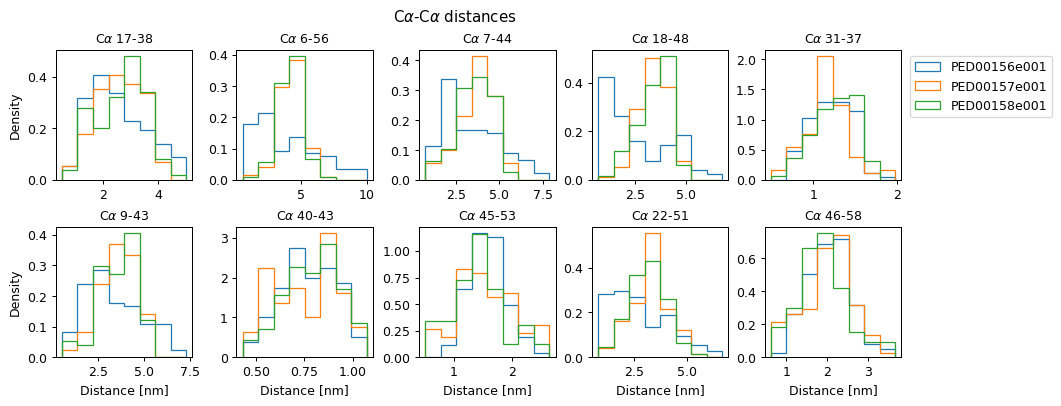

In [4]:
np.random.seed(2024)  # Set a random seed for reproducibility.
n_bins = 8

vis.plot_histogram_grid(
    feature="ca_dist",
    n_rows=2,
    n_cols=5,
    bins=n_bins
);
    

The ensembles are from the same disordered protein, so their histograms appear as similar.

However, we can clearly spot some differences: the distributions of PED00157 and PED00158 are more closely related to each other with respect to PED00156 (e.g.: see distance between residue index 6-56 and 18-48).

Note: in these plots the residue numbering starts from zero.

### $\alpha$ angles

Now, let’s plot the histograms of some random $\alpha$ angles. In this case, the differences are more subtle and difficult to catch by eye. This is why performing a quantitative analysis will help.

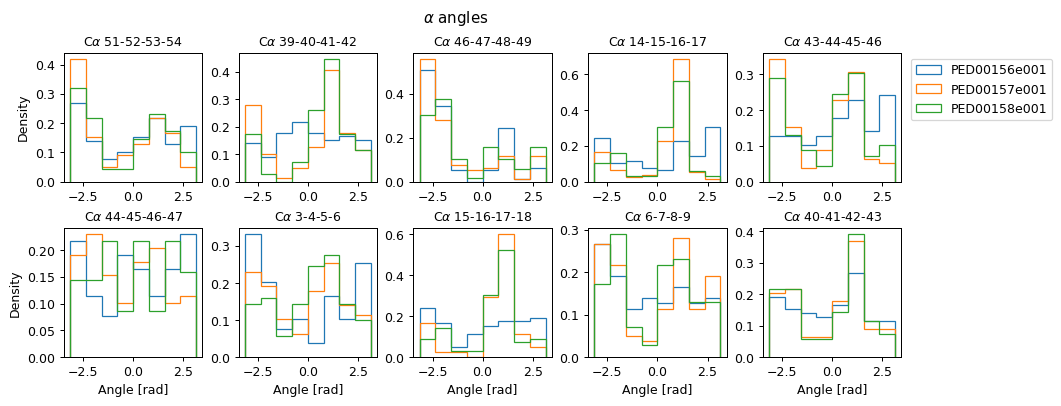

In [5]:
np.random.seed(2024)

vis.plot_histogram_grid(
    feature="a_angle",
    n_rows=2,
    n_cols=5,
    bins=n_bins
);

## Part 3: comparing ensembles with scores based on Jensen-Shannon entropy

Let's start the actual comparison. We will begin by using the a series of scores based on approximations of [Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen–Shannon_divergence) (JSD) between probability distributions.

We will use two scores:
- `aJSD_d`: compares at distributions of $C\alpha$-$C\alpha$ pairwise distances.
- `aJSD_t`: compares at distributions of $\alpha$ angles.

the lower the values of these scores are, the more similar two ensembles are (0 means identical ensembles). You can find details about these scores in [previous literature](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1012144).

By using the `comparison_matrix()` method of the `Visualization` class, we can easily perform an all-vs-all comparison between all the ensembles we are analyzing. The method will plot an matrix with scores between all pair of ensembles.


# Scoring 'jsd' using features 'ca_dist'
- Number of bins for all comparisons: 10
- We have 3 pairs of ensembles and will perform a total of 3 comparisons.
# Scoring 'jsd' using features 'alpha_angle'
- Number of bins for all comparisons: 10
- We have 3 pairs of ensembles and will perform a total of 3 comparisons.


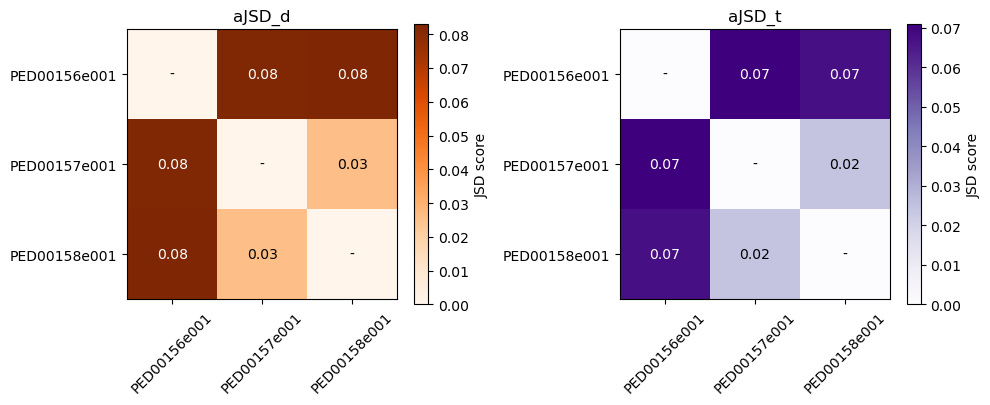

In [6]:
bins = "auto"

# Create a figure with two panels.
fig, ax = plt.subplots(1, 2, figsize=(10.0, 4))

# Plot on the left panel all-vs-all aJSD_d scores (compare Ca-Ca distances).
vis.comparison_matrix(
    score="jsd",
    feature="ca_dist",
    bins=bins,
    ax=ax[0],
    cmap="Oranges",
    verbose=True
)

# Plot on the right panel all-vs-all aJSD_t scores (compare alpha torsion angles).
vis.comparison_matrix(
    score="jsd",
    feature="alpha_angle",
    bins=bins,
    ax=ax[1],
    cmap="Purples",
    verbose=True
)

plt.tight_layout()
plt.show()

The scores in the heatmap confirm our initial observations.

Based on $C\alpha$-$C\alpha$ distance distributions (heatmap on the left), PED00157 and PED00158 are more similar to each other with respect to PED00156.

The comparison shows that the same trend appears to exists also for $\alpha$ angles distributions (heatmap on the right).

**NOTE**: We set the `bins` argument to `auto`. In IDPET, the JSD-based scores require discretizing data in histograms. The values of `bins` can influence the results. Unless there is a specific reason to change it, the safest option is to use the `auto` argument to let IDPET figure out the optimal number of bins.

## Part 4 (optional): comparing ensembles with scores based on Earth mover's distance

IDPET implements also a series of scores based on approximations of the [Earth mover’s distance]( https://en.wikipedia.org/wiki/Earth_mover%27s_distance) to compare ensembles.

These score can be used in the same way of the JSD-based scores illustrated above. They also look at $C\alpha$-$C\alpha$ distances and $\alpha$ torsion angles.

Also in this case, the lower these scores are, the more two ensembles resemble each other. When you run the cell below, see how the results are consistent with the ones obtained above with the JSD scores.

# Scoring 'emd' using features 'ca_dist'
- Distance function for comparing: rmsd
- We have 3 pairs of ensembles and will perform a total of 3 comparisons.
# Scoring 'emd' using features 'alpha_angle'
- Distance function for comparing: angular_l2
- We have 3 pairs of ensembles and will perform a total of 3 comparisons.


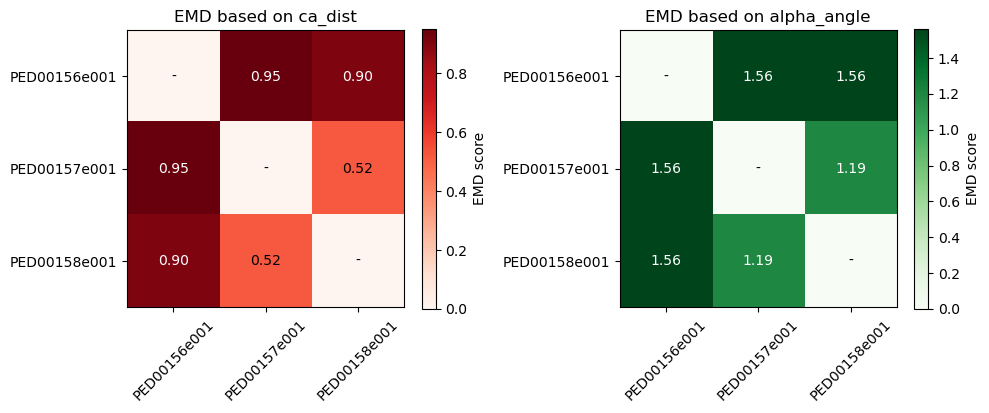

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10.0, 4))

vis.comparison_matrix(
    score="emd",
    feature="ca_dist",
    bins="auto",
    ax=ax[0],
    cmap="Reds",
    verbose=True
)

vis.comparison_matrix(
    score="emd",
    feature="alpha_angle",
    bins="auto",
    ax=ax[1],
    cmap="Greens",
    verbose=True
)

plt.tight_layout()
plt.show()

## Comment: how to select a score for comparing ensembles in IDPET?

Comparing structural ensembles of proteins is a very challenging task. Like most ensemble comparison methods, the scores implemented in IDPET are not a perfect solution. For example, they only look at coarse-grained properties ($C\alpha$ geometries), and do not consider all-atom details. Nevertheless they can provide useful information.

Which score implemented should you normally use to compare your ensembles in IDPET? Here are some tips:

- Based on our experience, aJSD_d is probably the best candidate for dynamic proteins. It captures both local and global/long-distance geometrical properties. If you want to use only one score in IDPET, this is probably the best choice.
- aJSD_t is specific to local backbone geometries. Use it to assess specifically this part of the ensembles.
- EMD-based scores should provide results similar to their JSD-based counterparts. They can represent a nice way to confirm results obtained with JSD-based scores, but are probably less robust to small ensembles (see below).
- **IMPORTANT**: When your ensembles are very small (less than 25-50 conformers), any of these scores will tend to fail at capturing existing differences. Use them with caution in these situations or maybe try to use a statistical approach (see below).

## Part 5: bootstrapping and statistical significance

The analysis from above outlined the relationships between the ensembles.

But are the results statistically significant? Those ensembles are quite small for a disordered protein: 100 or less conformers. Would the results change if we were to add or remove conformers?

To answer this question, we can perform a statistical analysis via bootstrapping. Just provide a `bootstrap_iters` argument to the `comparison_matrix()` method.

**Confidence intervals**

IDPET will perform the following analysis:
- Compare each pair of ensembles `bootstrap_iters` times, each time by subsampling conformers via bootstrapping. The scores in the heatmap are now confidence intervals in the form of `[lower, higher]`, estimated via boostrapping. The smaller (or sparser) an ensemble is, the larger the uncertainty should be.
- Compare each ensemble with itself by subsampling conformers with bootstrapping. Note how the diagonal of the heatmap also contains some values now. Those are the confidence levels for these auto-comparison scores.

**Statistical test**

A key question is: are the inter-ensemble scores (comparison of different ensembles) significantly higher than intra-ensemble scores (auto-comparisons)? In other words: is the divergence between ensemble $i$ and $j$ really higher than the one expected between different subsamples from ensemble $i$ (or $j$)?

To answer this question, IDPET uses the following strategy:
- For each ensemble pair $i$ and $j$, get the comparison scores obtained in bootstrapping, called the inter-ensemble scores.
- Get the bootstrapping scores from auto-comparisons of ensemble $i$ and $j$. The scores with the higher mean are selected as our reference intra-ensemble scores.
- Compare the inter-ensemble and intra-ensemble scores via a one-sided [Mann-Whitney U test](https://en.wikipedia.org/wiki/Mann–Whitney_U_test). The alternative hypothesis is: inter-ensemble scores are stochastically greater than intra-ensemble scores. If the null hypothesis (no difference) is rejected, an asterisk `*` will be shown beside the intervals in the heatmap.

In our example, it looks like that PED00157 and PED00158 have low aJSD_d scores, but these scores appear to be significantly higher than those obtained by auto-comparisons, hinting at a systematic difference.

# Scoring 'jsd' using features 'ca_dist'
- Number of bins for all comparisons: 10
- We have 6 pairs of ensembles and will perform a total of 300 comparisons.


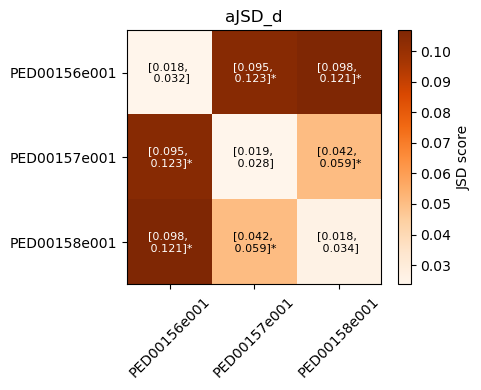

In [8]:
# Parameters.
bootstrap_iters = 25  # The more iterations, the better, but it will take more time.
bins = "auto"

# Create a figure with one panel.
fig, ax = plt.subplots(1, 1, figsize=(5.0, 4))

# Plot on the panel all-vs-all aJSD_d scores (compare Ca-Ca distances).
vis_out = vis.comparison_matrix(
    score="jsd",
    feature="ca_dist",
    bootstrap_iters=bootstrap_iters,
    bins=bins,
    ax=ax,
    cmap="Oranges",
    verbose=True,
    confidence_level=0.95,   # For confidence intervals shown in the plot.
    significance_level=0.05  # For the Mann-Whitney U test.
)

plt.tight_layout()
plt.show()

**NOTE**: performing this bootstrap analysis largely increases computational times. Use it only when you have a few ensembles and when those ensembles have a small number of conformers (less than 100). For larger ensembles, comparison scores in IDPET tend to be more robust. 

## Part 6: low-level usage of comparison functions

In this last part, let’s see another strategy to use comparison scores in IDPET. We will not directly use the `Visualization` class here, rather we will use low-level functions to perform comparisons.

First, let's import the necessary functions.


In [9]:
from dpet.comparison import (
    score_ajsd_d, get_ajsd_d_matrix,
    score_ajsd_t, get_ajsd_t_profile,
    score_avg_jsd,
    score_emd_approximation
)

Then, get the ensembles to compare.

In [10]:
ens_1 = analysis["PED00156e001"]
ens_2 = analysis["PED00157e001"]

### Computing JSD-based scores

Easy, quick way to compute aJSD_d and aJSD_t.

In [11]:
score, bins = score_ajsd_d(ens_1, ens_2, bins="auto", return_bins=True)
print(f"- aJSD_d score: {score:.4f}, bins used: {bins}")

score, bins = score_ajsd_t(ens_1, ens_2, bins="auto", return_bins=True)
print(f"- aJSD_t score: {score:.4f}, bins used: {bins}")

- aJSD_d score: 0.0825, bins used: 10
- aJSD_t score: 0.0709, bins used: 10


There is also a more complex way to compute aJSD values, which requires you to manually provide a `(N, F)` feature matrix. We only show how to do it for aJSD_t (aJSD_d is similar).

You can adapt it for any feature matrix of shape `(N, F)`.

You can also implement your own bootstrapping strategy with this system.

In [12]:
# Manually compute features (alpha_angles).
alpha_1 = ens_1.get_features(featurization="a_angle")
print("- features 1 shape:", alpha_1.shape)
alpha_2 = ens_2.get_features(featurization="a_angle")
print("- features 2 shape:", alpha_2.shape)

# Manually compute average JSD approximation. You can also provide any other
# 2d feature matrix as input to the `score_avg_jsd` function.
score, bins = score_avg_jsd(alpha_1, alpha_2, bins="auto", return_bins=True)
print(f"- aJSD_t score: {score:.4f}, bins used: {bins}")

- features 1 shape: (100, 56)
- features 2 shape: (100, 56)
- aJSD_t score: 0.0709, bins used: 10


### Computing EMD-based scores

Optionally, let's also manually compare ensembles with EMD scores.

You can adapt this code to any feature matrix of shape `(N, F)`.

In [13]:
# Let's compute features (alpha_angles).
alpha_1 = ens_1.get_features(featurization="a_angle")
print("- features 1 shape:", alpha_1.shape)
alpha_2 = ens_2.get_features(featurization="a_angle")
print("- features 2 shape:", alpha_2.shape)

# Manually score EMD approximation. NOTE: since we are comparing angular features,
# make sure to use `angular_l2` as the `metric` argument. For all other features
# (e.g.: interatomic distances) you should use `rmsd` or `l2` instead.
score = score_emd_approximation(alpha_1, alpha_2, metric="angular_l2")
print(f"- EMD on alpha angles: {score:.4f}")

- features 1 shape: (100, 56)
- features 2 shape: (100, 56)
- EMD on alpha angles: 1.5591


### Rationalizing JSD-based scores

Finally, IDPET allows you to analyze the results obtained by comparing two ensembles with aJSD_d or aJSD_t.

The aJSD_d score computes JSD approximations for all pairs of $C\alpha$-$C\alpha$ distances and then averages them. The aJSD_t score similarly compares all $\alpha$ angle distributions in the ensembles and then averages.

While an average score can provide useful information, looking at the pattern of individual JSD scores can help making better sense of the differences between two ensembles.

Via the `get_ajsd_d_matrix()` function you can access the raw scores for each $C\alpha$-$C\alpha$ distance. Use the `plot_jsd_d_matrix()` function to plot them.

Similarly, the `get_ajsd_t_profile()` function returns the scores for each $\alpha$ angle. Use the `plot_jsd_t_profile()` to plot them.

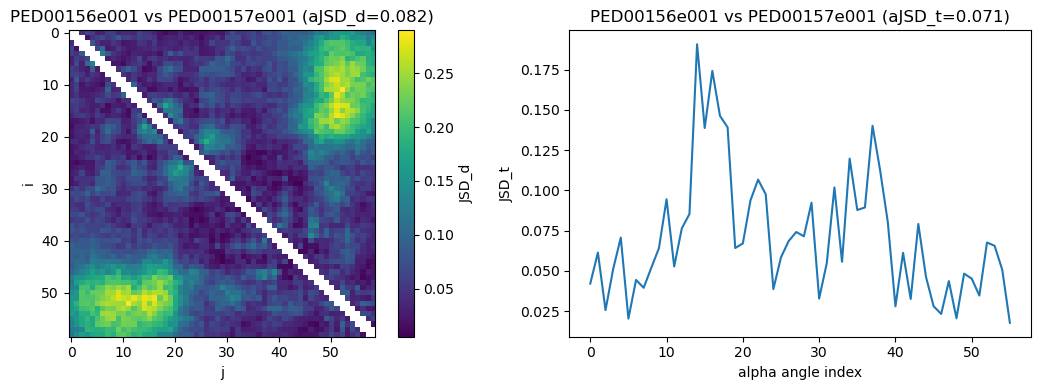

In [14]:
def plot_jsd_d_matrix(ens_1, ens_2, ax):
    # Compute JSD-based scores.
    avg_score, score_matrix = get_ajsd_d_matrix(
        ens_1, ens_2, bins="auto", return_bins=False
    )
    # Plot.
    ax.set_title(f"{ens_1.code} vs {ens_2.code} (aJSD_d={avg_score:.3f})")
    im = ax.imshow(score_matrix)
    ax.set_xlabel("j")
    ax.set_ylabel("i")
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.set_label("JSD_d")
    return ax


def plot_jsd_t_profile(ens_1, ens_2, ax):
    # Compute JSD-based scores.
    avg_score, score_profile = get_ajsd_t_profile(
        ens_1, ens_2, bins="auto", return_bins=False
    )
    # Plot.
    ax.set_title(f"{ens_1.code} vs {ens_2.code} (aJSD_t={avg_score:.3f})")
    im = ax.plot(score_profile)
    ax.set_xlabel("alpha angle index")
    ax.set_ylabel("JSD_t")
    return ax


fig, ax = plt.subplots(1, 2, figsize=(11, 4))
plot_jsd_d_matrix(ens_1=ens_1, ens_2=ens_2, ax=ax[0])

plot_jsd_t_profile(ens_1=ens_1, ens_2=ens_2, ax=ax[1])
plt.tight_layout()
plt.show()

The higher a JSD score is, the higher the divergence between two distributions.

Clearly, the differences in $C\alpha$-$C\alpha$ distances and $\alpha$ angles of PED00156 and PED00157 are localized to specific regions.

Let's confirm this by plotting some histograms of $C\alpha$-$C\alpha$ distances and $\alpha$ angles, specifically for those residues appearing to have high individual JSD scores.

The histograms reflect a difference in distributions between PED00156 and PED00157.

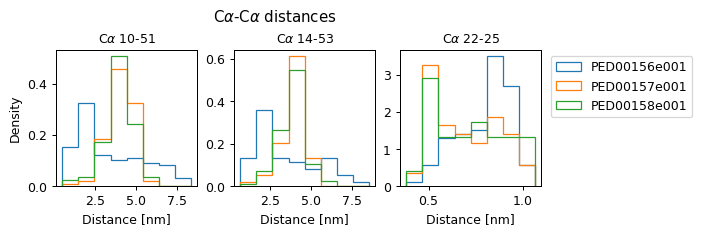

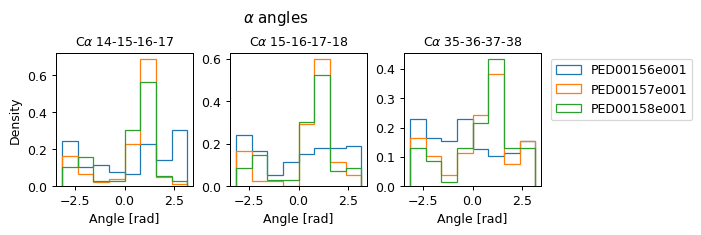

In [15]:
n_bins = 8

vis.plot_histogram_grid(
    feature="ca_dist",
    n_rows=1,
    n_cols=3,
    ids=[[10, 51], [14, 53], [22, 25]],  # Residue pairs appearing to have high JSD_d scores.
    bins=n_bins,
    subplot_width=2.0,
    subplot_height=2.5
);

vis.plot_histogram_grid(
    feature="a_angle",
    n_rows=1,
    n_cols=3,
    ids=[14, 15, 35],  # Residue indices appearing to have high JSD_t scores.
    bins=n_bins,
    subplot_width=2.0,
    subplot_height=2.5
);